In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
# from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

# Utilities

In [2]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
        and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
        this function assumes that the boxes to be plotted are groundtruth
        boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
        category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

In [48]:
from xml.etree.ElementTree import parse
def extractBoundingBoxInfo(filepath):
    xml_root = parse(filepath).getroot()
    img_height = float(xml_root.find("size").find("height").text)
    img_width = float(xml_root.find("size").find("width").text)
    bndbox_xmin = float(xml_root.find("object").find("bndbox").find("xmin").text)  / img_width
    bndbox_ymin = float(xml_root.find("object").find("bndbox").find("ymin").text)  / img_height
    bndbox_xmax = float(xml_root.find("object").find("bndbox").find("xmax").text)  / img_width
    bndbox_ymax = float(xml_root.find("object").find("bndbox").find("ymax").text)  / img_height
    bndbox_width = (bndbox_xmax - bndbox_xmin) / img_width
    bndbox_height = (bndbox_ymax - bndbox_ymin) / img_height
    return np.array([[bndbox_ymin, bndbox_xmin, bndbox_ymax, bndbox_xmax]], dtype=np.float32)

# Crayon Shin-chan toy data

We will be starting with some toy (literally) data consisting of 13 images of a Crayon Shin-chan stuffed toy. 

image file: 20201115_205142.jpg	annotation xml: 20201115_205142.xml
image file: 20201115_204921.jpg	annotation xml: 20201115_204921.xml
image file: 20201115_204955.jpg	annotation xml: 20201115_204955.xml
image file: 20201115_204717.jpg	annotation xml: 20201115_204717.xml
image file: 20201115_205152.jpg	annotation xml: 20201115_205152.xml
image file: 20201115_204520.jpg	annotation xml: 20201115_204520.xml
image file: 20201115_204810.jpg	annotation xml: 20201115_204810.xml
image file: 20201115_205250.jpg	annotation xml: 20201115_205250.xml
image file: 20201115_204638.jpg	annotation xml: 20201115_204638.xml
image file: 20201115_205021.jpg	annotation xml: 20201115_205021.xml
image file: 20201115_205258.jpg	annotation xml: 20201115_205258.xml
image file: 20201115_205208.jpg	annotation xml: 20201115_205208.xml
image file: 20201115_204529.jpg	annotation xml: 20201115_204529.xml


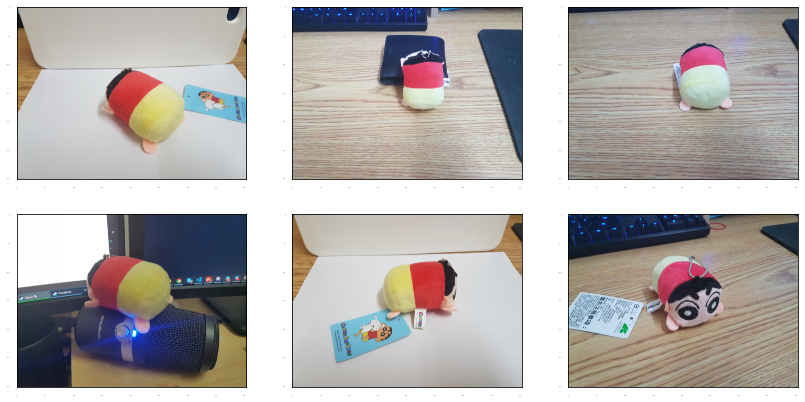

In [64]:
from pathlib import Path

# Load images and visualize
train_image_dir = Path('images/train/')
train_images_np = list()
gt_boxes = list()
for f in train_image_dir.iterdir():
    if f.suffix == '.jpg':
        print(f"image file: {f.name}\tannotation xml: {f.with_suffix('.xml').name}")
        train_images_np.append(load_image_into_numpy_array(str(f)))
        gt_boxes.append(extractBoundingBoxInfo(str(f.with_suffix('.xml'))))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np[:6]):
    plt.subplot(2, 3, idx+1)
    plt.imshow(train_image_np)
plt.show()

# Let's just visualize Shin-Chan as a sanity check

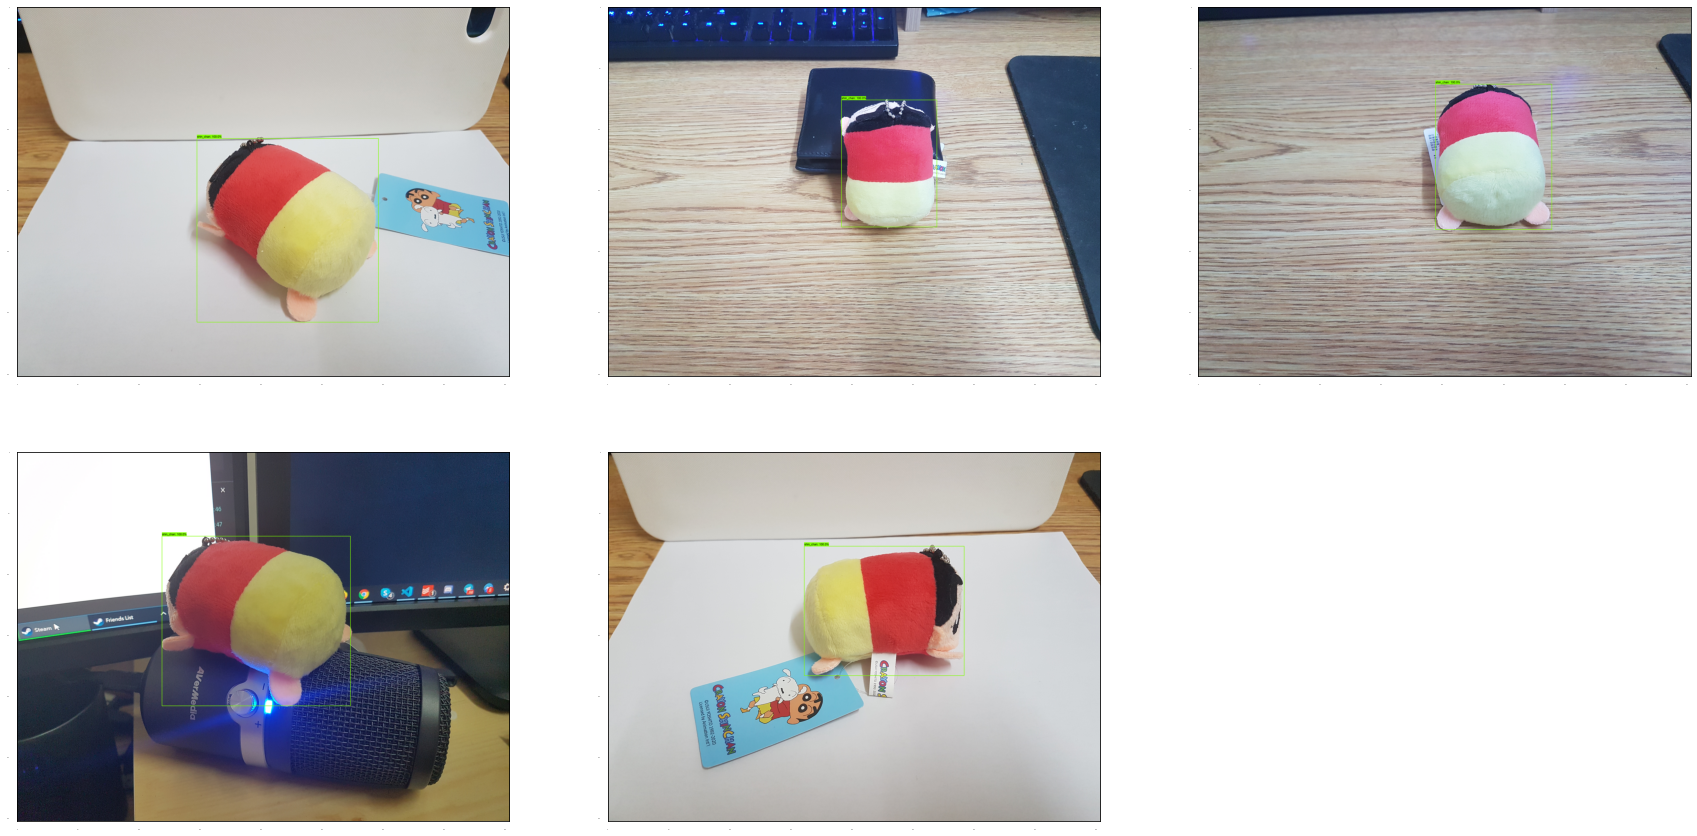

In [65]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

shinchan_id = 1
num_classes = 1

category_index = {shinchan_id: {'id': shinchan_id, 'name': 'shin_chan'}}

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes). We also convert everything to the format that the training loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [66]:
label_id_offset = 1
train_image_tensors = list()
gt_classes_one_hot_tensors = list()
gt_box_tensors = list()
for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [67]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!cp ~/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/

--2020-11-18 00:07:59--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.160.112, 2404:6800:4012:1::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.160.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  50.3MB/s    in 4.6s    

2020-11-18 00:08:04 (50.3 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]

mv: cannot move 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint' to 'models/research/object_detection/test_data/': No such file or directory
cp: -r not specified; omitting directory '/home/iceman126/models/research/object_detection/configs/tf2'


In [69]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [70]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    """Get a tf.function for training step."""

    # Use tf.function for a bit of speed.
    # Comment out the tf.function decorator if you want the inside of the
    # function to run eagerly.
    @tf.function
    def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
        """A single training iteration.

        Args:
            image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
            Note that the height and width can vary across images, as they are
            reshaped within this function to be 640x640.
            groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
            tf.float32 representing groundtruth boxes for each image in the batch.
            groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
            with type tf.float32 representing groundtruth boxes for each image in
            the batch.

        Returns:
            A scalar tensor representing the total loss for the input batch.
        """
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list)
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat(
                [detection_model.preprocess(image_tensor)[0]
                for image_tensor in image_tensors], axis=0)
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss

    return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Note that we do not do data augmentation in this demo.  If you want a
    # a fun exercise, we recommend experimenting with random horizontal flipping
    # and random cropping :)
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches)
        + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Start fine-tuning!
batch 0 of 100, loss=1.2376375
batch 10 of 100, loss=0.84540004
batch 20 of 100, loss=0.41783682
batch 30 of 100, loss=0.15251088
batch 40 of 100, loss=0.037511714
batch 50 of 100, loss=0.034283362
batch 60 of 100, loss=0.016907059
batch 70 of 100, loss=0.017561188
batch 80 of 100, loss=0.02316314
batch 90 of 100, loss=0.01416363
Done fine-tuning!


# Load test images and run inference with new model!

test image: 20201115_204553.jpg
test image: 20201115_205200.jpg


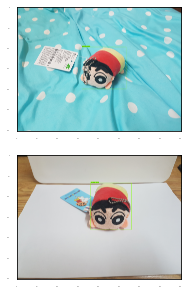

In [73]:
test_image_dir = Path('images/test/')
test_images_np = list()
for f in test_image_dir.iterdir():
    if f.suffix == '.jpg':
        print(f"test image: {f.name}")
        test_images_np.append(np.expand_dims(load_image_into_numpy_array(str(f)), axis=0))

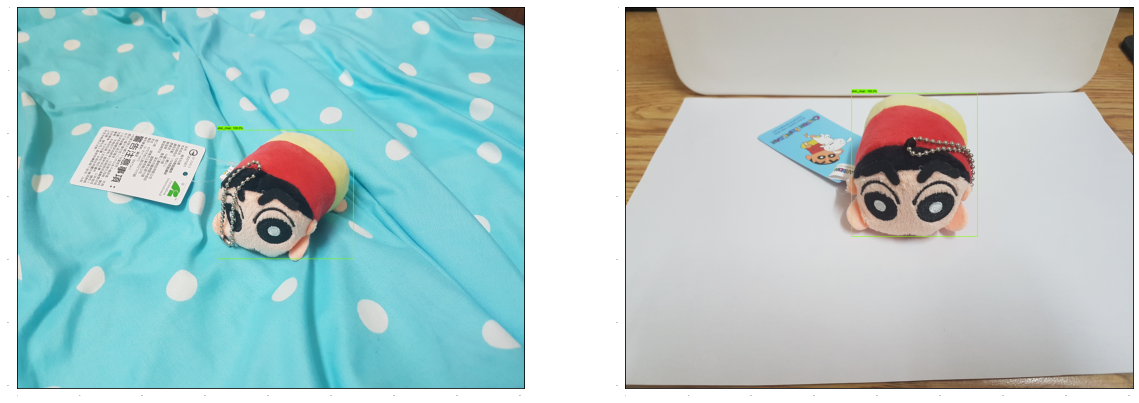

In [75]:
# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
        Note that height and width can be anything since the image will be
        immediately resized according to the needs of the model within this
        function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
        and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)


plt.figure(figsize=(20, 10))
label_id_offset = 1
for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plt.subplot(1, 2, i+1)
    plot_detections(
        test_images_np[i][0],
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.uint32)
        + label_id_offset,
        detections['detection_scores'][0].numpy(),
        category_index)
plt.show()